In [1]:
## Provide a wider display for easier viewing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## Ignore silly pandas warnings if they pop up

import warnings
warnings.filterwarnings("ignore")

In [3]:
## Import the necessary libraries
## This list will get modified as needed

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import *
import seaborn as sns
from sklearn.model_selection import *
from sklearn.metrics import *
import tensorflow as tf
import keras

Using TensorFlow backend.


In [4]:
## Confirm the versions of Keras and Tensorflow - to confirm we have the most up to date
## We should see 2.3 and 2.0

print(keras.__version__)
print()
print(tf.__version__)

2.3.0

2.0.0


# A. Project Background & Info.

<b>MSBA 6420 - Predictive Analytics - Group 1</b><br>
Analysts: Danny Moncada (monca016@umn.edu), Eduardo Chavez (echavezh@umn.edu)

## Google Analytics Customer Revenue Prediction [1]
-- Predict how much GStore customers will spend

## "The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

## RStudio, the developer of free and open tools for R and enterprise-ready products for teams to scale and share work, has partnered with Google Cloud and Kaggle to demonstrate the business impact that thorough data analysis can have.

## In this competition, you’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data."

[1]  Source: https://www.kaggle.com/c/ga-customer-revenue-prediction

In our predictive modeling analysis, we will perform the following steps:
    
1. Data Preprocessing and Loading
2. Feature Selection & Analysis
3. Model Creation & Assessment
4. Model Selection & Parameter Testing
5. Training & Testing Validations
6. Final Model & Predictions

In [ ]:
## Create a custom function to transform JSON formatted columns 

import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

print(os.listdir("../input"))

# A. Data Pre-processing and Loading

- We used BigQuery in Google Analytics to flatten the training and testing data sets into flattened files for easier consumption
- This required a custom function to read through all of the JSON columns and convert them into individual columns
- We then load the files that we flattened into the shared drive and start from here.

In [5]:
## Set the working directory

## Working directory
working_dir = "D:\\Group 1\\datasets\\"

## Training Data File - with flattened JSON fields
training_file = "train-flattened.csv"

## Full path to train data file
training_path = working_dir+training_file

## Testing Data File
testing_file = "test-flattened.csv"

## Full path to test data file
testing_path = working_dir+testing_file

In [6]:
training_path

'D:\\Group 1\\datasets\\train-flattened.csv'

In [7]:
## Load in the training data from the flattened CSV file

training_data = pd.read_csv(training_path)

In [8]:
## See the row count of the flattened file

len(training_data)

903653

## In the original training data file, the row count was 1.7 million - this has been drastically reduced with the flattened file.

In [9]:
## See the first five rows 

training_data.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [191]:
## Look at the column names - we have 55 features to choose from!

training_data.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

## Quite a significant amount of columns / features.  What are we really trying to assess?

- This is both a regression and classifcation problem; to perform the regression, we need a numeric field to use for predictions.  In this analysis, we can use the one labeled "totals.transactionRevenue".
- However, this doesn't provide us a target column for the classification problem, which is simply whether the customer spent money on the site or not.  We can simply create a new column labeled "Purchase", and assign a binary label (1, 0) to it, using the information from the "totals.transactionRevenue" column.  Let's see how this goes!

"What am I predicting?

We are predicting the <b>natural log</b> of the sum of all transactions <b>per user</b>. Once the data is updated, as noted above, this will be for <b>all users in test_v2.csv for December 1st, 2018 to January 31st, 2019</b>. For every user in the test set, the target is:"

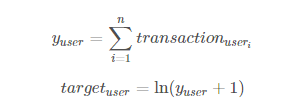

"<b>Note that the dataset does NOT contain data for December 1st 2018 to January 31st 2019. You must identify the unique fullVisitorIds in the provided test_v2.csv and make predictions for them for those unseen months.</b>" [1]

In [10]:
## Look at a few values for the transactionRevenue field

training_data["totals.transactionRevenue"].unique()

array([       nan, 3.7860e+07, 3.0667e+08, ..., 3.3526e+08, 3.0750e+07,
       6.9390e+07])

In [11]:
## Do a few things here - we'll see what values are NaN
## Then we can see what the spending column looks like

transaction_revenue_not_empty = training_data["totals.transactionRevenue"][training_data["totals.transactionRevenue"].notna()]

## Show the first five rows for Transaction Revenue 
transaction_revenue_not_empty.head()

752     37860000.0
753    306670000.0
799     68030000.0
802     26250000.0
859    574150000.0
Name: totals.transactionRevenue, dtype: float64

In [12]:
## Take a few example revenues and determine mathematically what the revenue column should look like:

print(37860000.0 / 1000000)

print(306670000.0 / 1000000)

print(574150000.0 / 1000000)

37.86
306.67
574.15


In [13]:
## How many rows actually contain revenue information?  In other words, how many rows in our training data have evidence of a purchase?

print("There are {} rows in the data set that actually contain purchase information.".format(len(transaction_revenue_not_empty)))

There are 11515 rows in the data set that actually contain purchase information.


## These values make much more sense than what was originally provided in the data set, at least from a business perspective.  If you want to accurately predict revenue, the output should be in a format that is understandable for the audience.

In [43]:
## As analysts, it helps us understand what problem we am trying to solve by viewing the data in a format that makes more sense.
## As a result, we can create two columns - a "new" revenue column with a denomation that makes more sense based on the simple math above
## And then a spending column with the binary (1, 0) target

In [14]:
## Create a new column labeled "Revenue" performing the calculation we identified above

training_data["Revenue"] = training_data["totals.transactionRevenue"] / 1000000

In [15]:
## Confirm our transformation completed successfully

training_data["Revenue"][training_data["Revenue"].notna()].head()

752     37.86
753    306.67
799     68.03
802     26.25
859    574.15
Name: Revenue, dtype: float64

In [16]:
## Next step - create a column labeled "Purchase" - for our classification analysis

## Where the "Revenue" column is not empty, assign the value 1 (for a purchase), otherwise give it a big fat 0
training_data["Purchase"] = np.where(training_data["Revenue"].notna(), 1, 0)

In [17]:
## Confirm that our new column was created successfully - we should see the same counts for 1 that we do for the row counts we did above

print(training_data.Purchase.value_counts())

print()

print(len(transaction_revenue_not_empty))

0    892138
1     11515
Name: Purchase, dtype: int64

11515


In [ ]:
## The row counts match!  So now we have our two different target columns, "Purchase" & "Revenue".
## We can move to the next step of splitting the data and transforming it, prior to performing a PCA on it.

In [18]:
## To make our analysis more efficient, and so we don't leave NaN in the Revenue column, we can replace them with 0.  This will help with averages, etc.
## Inplace = True is usually tricky but we'll be OK :)

training_data["Revenue"].fillna(0, inplace = True)

In [19]:
## Run very basic summary statistics on the training data, we can just very quickly see there are any strange outliers

training_data.describe()

,date,visitId,visitNumber,visitStartTime,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adwordsClickInfo.page,Revenue,Purchase
count,9.036530e+05,9.036530e+05,903653.000000,9.036530e+05,450630.0,903653.000000,703060.0,903553.000000,1.151500e+04,903653.0,21460.000000,903653.000000,903653.000000
mean,2.016589e+07,1.485007e+09,2.264897,1.485007e+09,1.0,4.596538,1.0,3.849764,1.337448e+08,1.0,1.008108,1.704273,0.012743
std,4.697698e+03,9.022124e+06,9.283735,9.022124e+06,0.0,9.641437,0.0,7.025274,4.482852e+08,0.0,0.173584,52.778659,0.112162
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09,1.0,1.000000,1.0,1.000000,1.000000e+04,1.0,1.000000,0.000000,0.000000
25%,2.016103e+07,1.477561e+09,1.000000,1.477561e+09,1.0,1.000000,1.0,1.000000,2.493000e+07,1.0,1.000000,0.000000,0.000000
50%,2.017011e+07,1.483949e+09,1.000000,1.483949e+09,1.0,2.000000,1.0,1.000000,4.945000e+07,1.0,1.000000,0.000000,0.000000
75%,2.017042e+07,1.492759e+09,1.000000,1.492759e+09,1.0,4.000000,1.0,4.000000,1.076550e+08,1.0,1.000000,0.000000,0.000000
max,2.017080e+07,1.501657e+09,395.000000,1.501657e+09,1.0,500.000000,1.0,469.000000,2.312950e+10,1.0,14.000000,23129.500000,1.000000


In [20]:
## This seems a bit awkwardly placed here - we are going to subset the data to remove a lot of detail that seems unnecessary

training_data_clean = training_data[['channelGrouping','date','socialEngagementType','visitNumber',
                            'geoNetwork.city', 'geoNetwork.country','totals.hits','totals.pageviews', 'totals.visits',
                            'trafficSource.adwordsClickInfo.adNetworkType','trafficSource.source','totals.transactionRevenue',
                                    "Revenue", "Purchase"]]

## Again with the risky filling of Null values!
training_data_clean["totals.pageviews"].fillna(0, inplace = True)

## Transform page views into an integer field
training_data_clean["totals.pageviews"] = training_data_clean["totals.pageviews"].astype(int)

## Run some summary statistics on the table
training_data_clean.describe()

,date,visitNumber,totals.hits,totals.pageviews,totals.visits,totals.transactionRevenue,Revenue,Purchase
count,9.036530e+05,903653.000000,903653.000000,903653.000000,903653.0,1.151500e+04,903653.000000,903653.000000
mean,2.016589e+07,2.264897,4.596538,3.849338,1.0,1.337448e+08,1.704273,0.012743
std,4.697698e+03,9.283735,9.641437,7.025002,0.0,4.482852e+08,52.778659,0.112162
min,2.016080e+07,1.000000,1.000000,0.000000,1.0,1.000000e+04,0.000000,0.000000
25%,2.016103e+07,1.000000,1.000000,1.000000,1.0,2.493000e+07,0.000000,0.000000
50%,2.017011e+07,1.000000,2.000000,1.000000,1.0,4.945000e+07,0.000000,0.000000
75%,2.017042e+07,1.000000,4.000000,4.000000,1.0,1.076550e+08,0.000000,0.000000
max,2.017080e+07,395.000000,500.000000,469.000000,1.0,2.312950e+10,23129.500000,1.000000


In [21]:
## Remove any columns that will not be used as features
## I will remove the visitId, visitNumber

feature_cols = training_data_clean.columns[~training_data_clean.columns.isin(["totals.transactionRevenue", "Revenue", "Purchase"])]

print(len(feature_cols))
print()
print(feature_cols)

11

Index(['channelGrouping', 'date', 'socialEngagementType', 'visitNumber',
       'geoNetwork.city', 'geoNetwork.country', 'totals.hits',
       'totals.pageviews', 'totals.visits',
       'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.source'],
      dtype='object')


In [22]:
## Fill in any other NaN values with "N/A"

## Build a list of categorical columns of our "clean" training data set - using a filter on columns with string values
categorical_columns = list(training_data_clean.columns[training_data_clean.dtypes == object])

## Fill the columns with string values with a "N/A" instead of an NaN - so that our encoders will work properly!
## Keep using that inplace = True!
training_data_clean[categorical_columns] = training_data_clean[categorical_columns].fillna("NA")

training_data_clean.head()

,channelGrouping,date,socialEngagementType,visitNumber,geoNetwork.city,geoNetwork.country,totals.hits,totals.pageviews,totals.visits,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.source,totals.transactionRevenue,Revenue,Purchase
0,Organic Search,20160902,Not Socially Engaged,1,Izmir,Turkey,1,1,1,NA,google,NaN,0.0,0
1,Organic Search,20160902,Not Socially Engaged,1,not available in demo dataset,Australia,1,1,1,NA,google,NaN,0.0,0
2,Organic Search,20160902,Not Socially Engaged,1,Madrid,Spain,1,1,1,NA,google,NaN,0.0,0
3,Organic Search,20160902,Not Socially Engaged,1,not available in demo dataset,Indonesia,1,1,1,NA,google,NaN,0.0,0
4,Organic Search,20160902,Not Socially Engaged,2,not available in demo dataset,United Kingdom,1,1,1,NA,google,NaN,0.0,0


In [23]:
## Create our "X" variable that contains all the features we would like to use for our model(s)
X = np.array(training_data_clean[feature_cols])

## Create our first "y" variable - for our classification problem
y_classification = np.array(training_data_clean["Purchase"])

## Create our second "y" variable - for our regression problem
y_regression = np.array(training_data_clean["Revenue"])

## Now we have a dual problem that we want to tackle, and we have FIFTY-TWO features columns, opening the door for the "curse of dimensionality"*

#### Curse of dimensionality: 

1.  More dimensions leads <i>sparser</i> data
2.  "Noise" from irrelevant dimensions affect the “signal” from relevant dimensions
3.  Distance metrics become increasingly less useful with more dimenions (which is important to us when trying to use KNN)
4.  Probability distributions behave non-intuitively in high-dimensional spaces

In [232]:
## Split data training 80 % and testing 20%
## We won't stratify the data for this part of the analysis - since we're performing a regression

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size = 0.2, random_state = 42)

In [233]:
X_train_reg

array([['Organic Search', 20161225, 'Not Socially Engaged', ..., 1, 'NA',
        'google'],
       ['Social', 20161103, 'Not Socially Engaged', ..., 1, 'NA',
        'youtube.com'],
       ['Organic Search', 20170506, 'Not Socially Engaged', ..., 1, 'NA',
        'google'],
       ...,
       ['Referral', 20170428, 'Not Socially Engaged', ..., 1, 'NA',
        'siliconvalley.about.com'],
       ['Organic Search', 20161220, 'Not Socially Engaged', ..., 1, 'NA',
        'google'],
       ['Organic Search', 20170412, 'Not Socially Engaged', ..., 1, 'NA',
        'google']], dtype=object)

## One of the things we notice here is that many of the features columns are categorical values.  This is not going to play well with many, if not all of the different data mining techniques we have used previously.

## Therefore, we need to "label" encode all of our features columns that are categorical.

In [30]:
## Create a new LabelEncoder object - this is what we'll use to actually encode the values.

le = preprocessing.LabelEncoder()
print(le)

print()

oe = preprocessing.OrdinalEncoder()
print(oe)

LabelEncoder()

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)


In [275]:
fit_oe = oe.fit(X_train_reg)
X_train_reg_encoded = fit_oe.transform(X_train_reg)

In [277]:
len(X_train_reg_encoded)

722922

In [279]:
X_train_reg_encoded.shape

(722922, 11)

## Now that we FINALLY have the training labeled in the correct manner, we will assess which features are actually needed.

## To do this, we will use a `Principle Component Analysis` and `Feature Importance Plot`.

In [289]:
## We normalize our training and testing data PCA to work correctly
## We don't want to skew the results of the plot because some features are not on the same scale
## We perform this normalization AFTER splitting the data - again, so that we don't skew the training
## data with the testing data.

## Normalization is the process of scaling individual samples to have unit norm. This process can be useful 
## if you plan to use a quadratic form such as the dot-product or any other kernel to quantify the similarity of any pair of samples.
X_train_reg_norm = preprocessing.Normalizer(norm = "l1").fit_transform(X_train_reg_encoded)
X_train_reg_robust = preprocessing.RobustScaler().fit_transform(X_train_reg_encoded)
X_train_reg_power = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(X_train_reg_encoded)
X_train_reg_standard = preprocessing.StandardScaler().fit_transform(X_train_reg_encoded)

## Import PCA from sklearn
from sklearn.decomposition import PCA

## Initialize two new PCA instances, we'll use this to plot the training data using two different transformations
## Normalizer will likely be skewed by the outliers in each of the features being used
## Robust is going to transform feature values to be larger than the previous scalers and more importantly are approximately similar to original data
## PowerTransformer is a family of parametric, monotonic transformations that aim to map data from any distribution to as close to a Gaussian distribution 
## as possible in order to stabilize variance and minimize skewness.

pca_v = PCA()
pca_n = PCA()
pca_r = PCA()
pca_p = PCA()
pca_s = PCA()

## The goal of this plot is to determine what features need to be included in our models
## In the first few homeworks, we threw the kitchen sink at the models.  Here, we are going to be
## more refined in our analysis.

## Train the PCA instance using the normalized training data

## Vanilla/plain/no transformation
pca_v.fit(X_train_reg_encoded)

## Normalized training data
pca_n.fit(X_train_reg_norm)

## Robust training data
pca_r.fit(X_train_reg_robust)

## Power Transformed training data
pca_p.fit(X_train_reg_power)

## Standardized training data
pca_s.fit(X_train_reg_standard)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

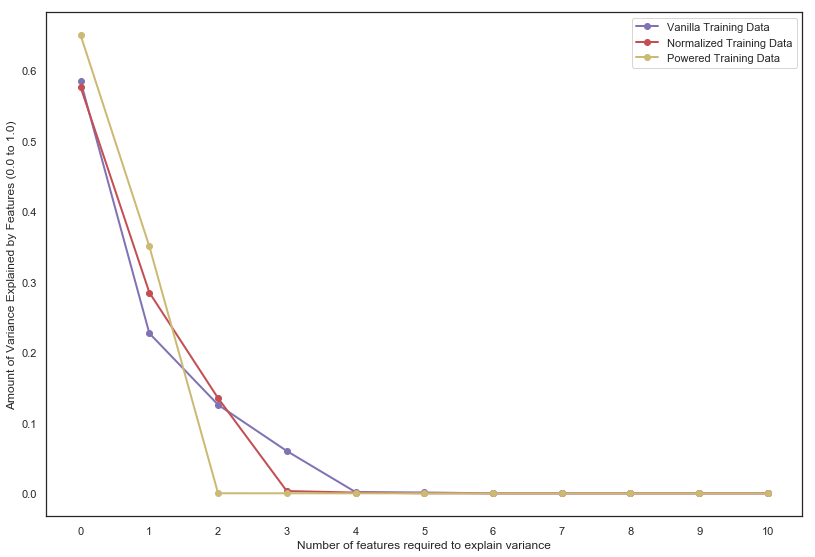

In [305]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Generate a new plot
plt.figure(1, figsize=(15, 10))
plt.clf()
plt.axes([.2, .2, .7, .7])

plt.plot(pca_v.explained_variance_ratio_, 'm-o', linewidth = 2, label = "Vanilla Training Data")
plt.plot(pca_n.explained_variance_ratio_, 'r-o', linewidth = 2, label = "Normalized Training Data")
#plt.plot(pca_r.explained_variance_ratio_, 'b-o', linewidth = 2, label = "Robusted Training Data")
plt.plot(pca_p.explained_variance_ratio_, 'y-o', linewidth = 2, label = "Powered Training Data")
#plt.plot(pca_s.explained_variance_ratio_, 'k-o', linewidth = 2, label = "Standardized Training Data")

## Set plot labels
plt.xlabel('Number of features required to explain variance')
plt.ylabel('Amount of Variance Explained by Features (0.0 to 1.0)')
plt.legend()

## Explicitly set the x-axis data so we can see where the drop-off is
plt.xticks(np.arange(0, 11, step=1))

## Show the graph!
plt.show()

In [303]:
## SET A VARIABLE TO SWAP IN AND OUT BETWEEN THE DIFFERENT TRAINING INSTANCES

#Z = X_train_reg_encoded
#Z = X_train_reg_norm
#Z = X_train_reg_robust
#Z = X_train_power
Z = X_train_reg_standard

Feature ranking:
1. feature 3 (0.378317)
2. feature 1 (0.211950)
3. feature 6 (0.156055)
4. feature 7 (0.150919)
5. feature 4 (0.052406)


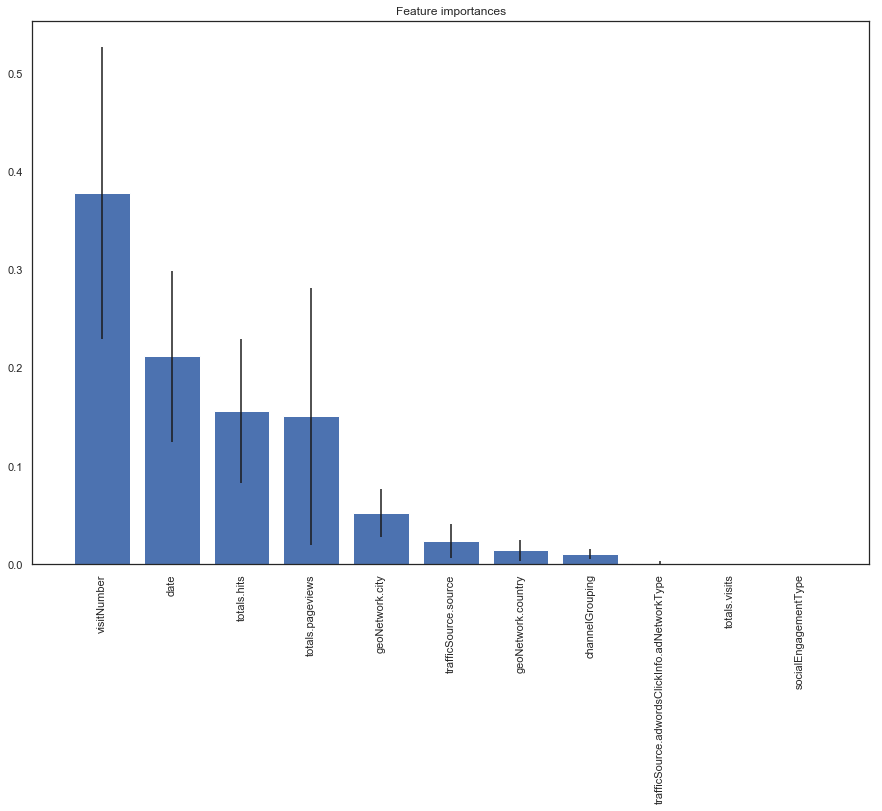

In [304]:

## Start with identifying the best features using a Random Forest classifier

## Create a new classifier
clf_rf_5 = ensemble.RandomForestRegressor()      
clr_rf_5 = clf_rf_5.fit(Z, y_train_reg)

## Save our importances to a variable
importances = clr_rf_5.feature_importances_

## Get the standard deviation for each feature
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

## Print the feature ranking
print("Feature ranking:")

## Print the top five features, and their importance based on the Random Forest Classifier
for f in range(0, 5):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


## Plot the feature importances of the Random Forest Regressor - to see this visually

## Set the plot size
plt.figure(1, figsize=(15, 10))

## Set the title
plt.title("Feature importances")

## Plot a graph using all of the normalized features
plt.bar(range(Z.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")

plt.xticks(range(Z.shape[1]), feature_cols[indices], rotation=90)
plt.xlim([-1, Z.shape[1]])

## Show the graph!
plt.show()

## Here are the features that we've identified as the most important for our model:

1. visitNumber
2. date
3. total.hits
4. totalspageviews
5. geoNetwork.cty 
6. geoNetwork.state
7. traffic source

## Algorithm Selection

## Now that we've identified our best features, we will re-initialize our training and testing data, and move on to the algorithm selection for the regression.

In [24]:
## Set a new variable with the columns we identified in our feature analysis

final_feature_cols = ["visitNumber", "date", "totals.hits", "totals.pageviews", 
                      "geoNetwork.city", "geoNetwork.country", "trafficSource.source"]

In [25]:
## Since we're running a regression, we don't need any of the rows that have $0.00 in spend - this just adds noise to the model
## We can just subset the data and remove these rows

spending_only = training_data_clean["Revenue"] != 0

spending_only_df = training_data_clean[spending_only]

In [26]:
## Create our "X" variable that contains all the features we would like to use for our model(s)
X = np.array(spending_only_df[final_feature_cols])

## Create our second "y" variable - for our regression problem
y_regression = np.array(spending_only_df["Revenue"])

In [27]:
## Split data training 80 % and testing 20%
## We won't stratify the data for this part of the analysis - since we're performing a regression

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size = 0.2, random_state = 42)

In [31]:
## Encode the categorical data

fit_oe = oe.fit(X_train_reg)
X_train_reg_encoded = fit_oe.transform(X_train_reg)

In [32]:
X_train_reg_encoded

array([[  0., 118.,  32., ...,  27.,  62.,  23.],
       [  0., 355.,  20., ..., 121.,  62.,   0.],
       [  0., 186.,  38., ...,  96.,  62.,   0.],
       ...,
       [  3.,  43.,  14., ..., 121.,  62.,   7.],
       [  2., 210.,  20., ...,  58.,  62.,  23.],
       [  3., 217.,  20., ...,  95.,  62.,  23.]])

In [333]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, KFold

In [338]:
## Let's try GBOOST

## Set up a grid for GBoost
### Use least squares for the regression
gbr_p_grid = {'loss': ['ls'], 
                 'n_estimators': [100, 200, 300, 400, 500], 
                 'max_depth': [3, 4, 5],
                 'min_samples_split': [2, 4, 6], 
                 'learning_rate': [0.01]}

In [334]:
## Set a number of trials to run for the models

num_trials = 20

## Empty arrays to store scores for classifier

nested_scores_gbr = np.zeros(num_trials)

In [336]:
## Gradient Boost
gbr = ensemble.GradientBoostingRegressor()

In [343]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Logit Regression
    
    gbreg= GridSearchCV(estimator=gbr, param_grid=gbr_p_grid, cv=inner_cv, scoring = "neg_mean_squared_error")
    gbreg.fit(X_train_reg_encoded, y_train_reg)
    
    nested_score = cross_val_score(gbreg, X = X_train_reg_encoded, y = y_train_reg, cv = outer_cv, scoring = "neg_mean_squared_error")
    nested_scores_gbr[i] = nested_score.mean()

C:\Python\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Python\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Python\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Python\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from

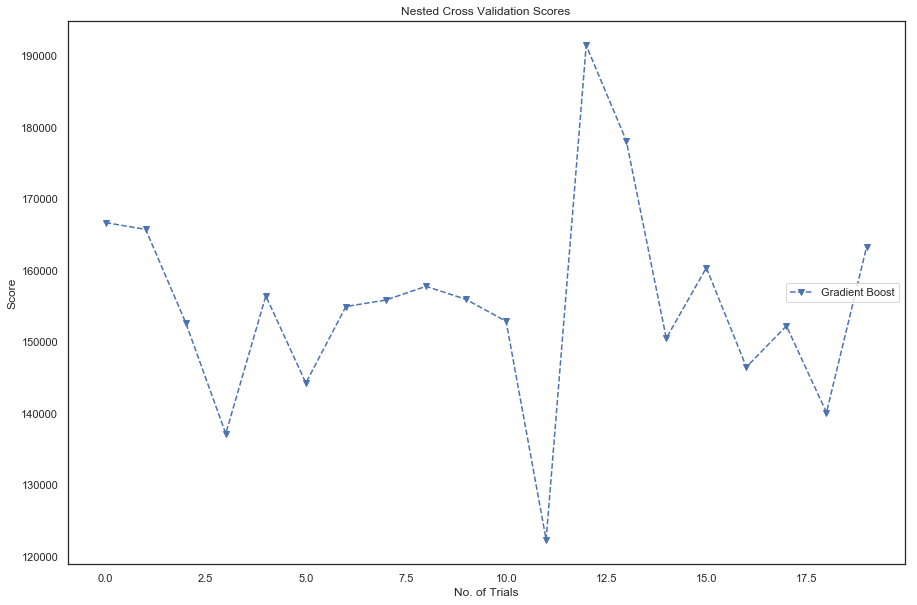

In [346]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each trial for nested CV

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot nested scores for each classifier - quickly visual the best performing model
## This is WITHOUT having changed any of the default parameters
plt.plot(nested_scores_gbr*-1, 'v--', label = "Gradient Boost")

## Give some labels
plt.xlabel("No. of Trials")
plt.ylabel("Score")

## Title and legend
plt.title("Nested Cross Validation Scores")
plt.legend(loc = 'center right')

## Show the graph
plt.show()

In [351]:
## Get our best params
print(gbreg.best_params_)
print()

## Print out how well it performed using the best params
# print(gbreg.best_score_*-1)
print(max(nested_scores_gbr)*-1)

{'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}

122344.24405501428


In [359]:
gboost_regression_results_df = pd.DataFrame(gbreg.cv_results_)

In [361]:
gboost_regression_results_df[gboost_regression_results_df["rank_test_score"] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,param_min_samples_split,param_n_estimators,params,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
30,0.434278,0.002585,0.007501,0.000501,0.01,ls,5,2,100,"{'learning_rate': 0.01, 'loss': 'ls', 'max_dep...",...,-135985.513087,-159382.711206,63581.831147,1,-92558.056364,-84116.570548,-95780.325429,-80132.727874,-88146.920054,6288.839213


## Here are the results of the gradient boosted algo <i>without</i> normalization of the training data.  This could possibly be one of the reasons that the model did not perform well.  Before we try any other algorithms, let's normalize the data first.

In [36]:
## We have a few different options here for standardizing the data set
## We can try one or two to see if they help with the model performance

X_train_reg_norm = preprocessing.Normalizer(norm = "l1").fit_transform(X_train_reg_encoded)
X_train_reg_robust = preprocessing.RobustScaler().fit_transform(X_train_reg_encoded)
X_train_reg_power = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(X_train_reg_encoded)
X_train_reg_standard = preprocessing.StandardScaler().fit_transform(X_train_reg_encoded)

In [48]:
print("Here is the output of 'normalized' training data: \n\n{}".format(X_train_reg_norm[0]))

print()

print("Here is the output of 'standardized' training data: \n\n{}".format(X_train_reg_standard[0]))

print()

print("Here is the output of 'robust' training data: \n\n{}".format(X_train_reg_robust[0]))

Here is the output of 'normalized' training data: 

[0.         0.40549828 0.10996564 0.09965636 0.09278351 0.21305842
 0.0790378 ]

Here is the output of 'standardized' training data: 

[-0.39815549 -0.59999724 -0.06630944  0.1656382  -1.79721072  0.18745187
  0.89148288]

Here is the output of 'robust' training data: 

[-0.33333333 -0.33695652  0.24        0.44444444 -1.30188679  0.
  1.        ]


In [52]:
## Here's our spread of target variables, the revenue.  We see a massive split

print(min(y_train_reg))

print()

print(max(y_train_reg))

0.09

23129.5


In [58]:
## 
y_train_reg_robust = preprocessing.RobustScaler().fit_transform(y_train_reg.reshape(-1, 1))

y_train_reg_robust = y_train_reg_robust.flatten()

y_train_reg_robust

array([-0.14856076, -0.36522944, -0.43773335, ...,  1.45856919,
       -0.30501024,  3.88275322])

In [71]:
## Initiate a new instance of Decision Tree Regressor
dtr = tree.DecisionTreeRegressor()

## Set up a grid for the DecisionTree Regressor
dtr_p_grid = {"criterion": ["mse"],
            "splitter": ["best", "random"],
            "max_features": [4, 5, 6],
            "max_depth": [5, 10, 15]}

## Set a number of trials to run for the models

num_trials = 20

## Empty arrays to store scores for classifier

nested_scores_dtr = np.zeros(num_trials)

In [72]:
## Remove annoying DeprecationWarnings from sklearn - I will upgrade after this project!

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [73]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for DecisionTree Regressor
    
    dtreg= GridSearchCV(estimator=dtr, param_grid=dtr_p_grid, cv=inner_cv, scoring = "neg_mean_squared_error")
    dtreg.fit(X_train_reg_robust, y_train_reg_robust)
    
    nested_score = cross_val_score(dtreg, X = X_train_reg_robust, y = y_train_reg_robust, 
                                   cv = outer_cv, scoring = "neg_mean_squared_error")
    
    nested_scores_dtr[i] = nested_score.mean()

In [79]:
## Set up a grid for kNN Regressor
## Going to use 1-30 neighbors, and two different distance calculations
knnr_p_grid = {"n_neighbors": list(range(1, 31)),
             "weights": ["uniform", "distance"]}

## Empty array to contain scores
nested_scores_knnr = np.zeros(num_trials)

## Initiate a new instance of k-Nearest Neighbors object
knnr = neighbors.KNeighborsRegressor()

In [80]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for kNN Regression
    
    knnreg= GridSearchCV(estimator=knnr, param_grid=knnr_p_grid, cv=inner_cv, scoring = "neg_mean_squared_error")
    knnreg.fit(X_train_reg_robust, y_train_reg_robust)
    
    nested_score = cross_val_score(knnreg, X = X_train_reg_robust, y = y_train_reg_robust, cv = outer_cv, scoring = "neg_mean_squared_error")
    nested_scores_knnr[i] = nested_score.mean()

In [84]:
## Using L1 only, this is a SPARSE data set with outliers affecting the ability of the algorithms to perform the regression.
lr_p_grid = {"penalty": ["l1"],
            "C": [1, 5, 10, 50, 1000],
            "solver": ["liblinear"]}

## Empty array to contain scores
nested_scores_lr = np.zeros(num_trials)

## Linear Regression
lr = linear_model.LogisticRegression()

In [81]:
nested_scores_knnr*-1

array([24.0707382 , 21.95758347, 29.85873953, 20.5122735 , 22.42895763,
       24.91457173, 27.15988458, 22.18264625, 24.66857387, 27.30952729,
       23.7622061 , 27.12216166, 28.39615459, 23.08889251, 24.5915435 ,
       25.30453033, 27.42257336, 24.48367745, 22.27836749, 27.88740492])

In [88]:
y_train_reg_robust_int = y_train_reg_robust.astype(int)

In [89]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Logit Regression
    
    lreg= GridSearchCV(estimator=lr, param_grid=lr_p_grid, cv=inner_cv, scoring = "neg_mean_squared_error")
    lreg.fit(X_train_reg_robust, y_train_reg_robust_int)
    
    nested_score = cross_val_score(lreg, X = X_train_reg_robust, y = y_train_reg_robust_int, cv = outer_cv,
                                  scoring = "neg_mean_squared_error")
    
    nested_scores_lr[i] = nested_score.mean()

C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: Co

C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: Co

C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: Co

C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: Co

C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: Co

C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: Co

C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: Co

C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Python\lib\site-packages\sklearn\svm\base.py:931: Co

KeyboardInterrupt: 

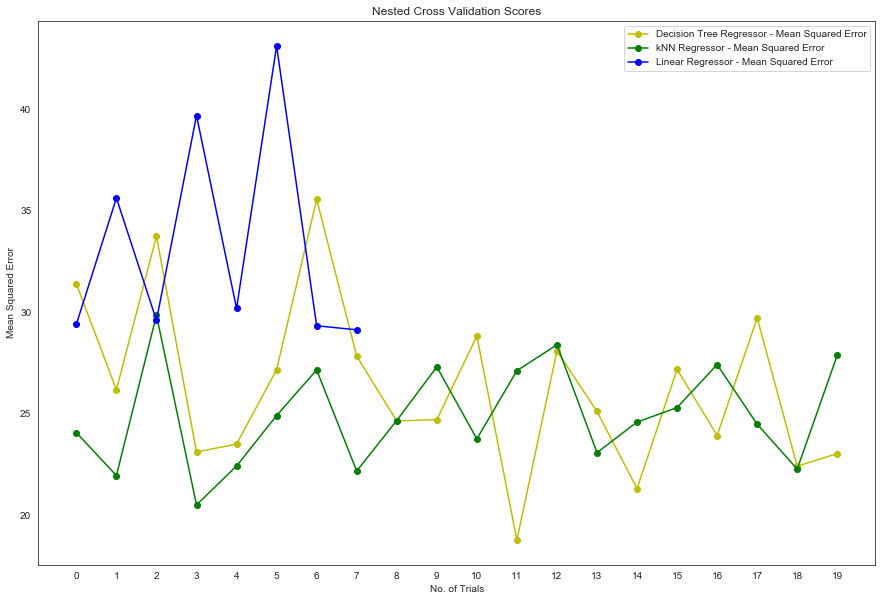

In [96]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each trial for nested CV

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot nested scores for each classifier - quickly visual the best performing model
## This is WITHOUT having changed any of the default parameters
plt.plot(nested_scores_dtr*-1, 'y-o', label = "Decision Tree Regressor - Mean Squared Error")
plt.plot(nested_scores_knnr*-1, 'g-o', label = "kNN Regressor - Mean Squared Error")
plt.plot(nested_scores_lr[:8]*-1, 'b-o', label = "Linear Regressor - Mean Squared Error")

## Give some labels
plt.xlabel("No. of Trials")
plt.ylabel("Mean Squared Error")
plt.xticks(np.arange(0, 20, step = 1))

## Title and legend
plt.title("Nested Cross Validation Scores")
plt.legend()

## Show the graph
plt.show()

In [97]:
nested_scores_dtr

array([-31.39943409, -26.18296908, -33.74390274, -23.11733997,
       -23.50775031, -27.17223886, -35.56159496, -27.83744961,
       -24.64392742, -24.71263695, -28.82238863, -18.78039797,
       -28.09451221, -25.1155978 , -21.31882621, -27.19112995,
       -23.92971138, -29.72257172, -22.41733448, -23.04114399])

In [98]:
nested_scores_knnr

array([-24.0707382 , -21.95758347, -29.85873953, -20.5122735 ,
       -22.42895763, -24.91457173, -27.15988458, -22.18264625,
       -24.66857387, -27.30952729, -23.7622061 , -27.12216166,
       -28.39615459, -23.08889251, -24.5915435 , -25.30453033,
       -27.42257336, -24.48367745, -22.27836749, -27.88740492])

In [99]:
nested_scores_lr

array([-29.40859748, -35.62548849, -29.59769865, -39.6859531 ,
       -30.18584455, -43.11278767, -29.33184976, -29.13547547,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [ ]:
## Add annotation that training stop after 8 cycles due to locks on the VMs

In [ ]:
## Import our libraries needed to build the models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
## Cycle through these different hidden units with our two layer model - renamed it since we'll be keeping this the same for the three layer model as well.

nb_hiddens = np.array([24, 48, 128, 256])

In [ ]:
## Create a function to build the two layer model
def test_model_two(activation='relu', nb_hidden = 120):
    
    two_layer_model = Sequential()
    
    ## The first hidden layer will cycle through different hidden layers
    ## The model expects rows of data with 1 variable (the input_dim=1 argument)
    two_layer_model.add(Dense(nb_hidden, input_dim = 1, activation = "relu"))
    
    ## The second hidden layer will have the same number of hidden units as the first layer and uses the relu activation function.
    two_layer_model.add(Dense(nb_hidden, activation = "relu"))
    
    ## The output layer has one node and uses the linear activation function.
    two_layer_model.add(Dense(1, activation = "linear"))
    
    ## We will define the optimizer as the efficient stochastic gradient descent algorithm "adam". 
    ## This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems.
    two_layer_model.compile(loss = "mse", optimizer = "adam", metrics = ["mse"])
    
    ## Return the completed model
    return two_layer_model

In [ ]:
## Save our results to an empty list so that we can capture this and plot it later
two_layer_model_results = []

## Loop through all of the hidden layers and replace the hidden units in each iteration of tests
for i in nb_hiddens:
    
    ## Establish a new version of our model above
    two_layer_model = test_model_two(nb_hidden = i)
    
    ## Save the history of the model and use 15% of the training data to validate our model results
    history = two_layer_model.fit(X_train, y_train, epochs = 20, verbose = 0, validation_split = 0.15)
    
    ## Save the results into the list above
    two_layer_model_results.append(history)

In [ ]:
## Save our results to a new set of variables - so that we don't lose the history or the output from the first model run
first_run_loss_b = two_layer_model_results[0].history['loss']
second_run_loss_b = two_layer_model_results[1].history['loss']
third_run_loss_b = two_layer_model_results[2].history['loss']
fourth_run_loss_b = two_layer_model_results[3].history['loss']

## Save the results of our validation MSE as well - whichever does the best from the three will get tested with the actual data
first_run_mse_b = two_layer_model_results[0].history['val_mse']
second_run_mse_b = two_layer_model_results[1].history['val_mse']
third_run_mse_b = two_layer_model_results[2].history['val_mse']
fourth_run_mse_b = two_layer_model_results[3].history['val_mse']

In [ ]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each trial for nested CV

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot Mean Squared Error to quickly visual the best performing two layer model
plt.plot(first_run_mse_b, 'r-o', label = "Two Layers / 24 hidden units - Validation MSE")
plt.plot(second_run_mse_b, 'y-o', label = "Two Layers / 48 hidden units - Validation MSE")
plt.plot(third_run_mse_b, 'g-o', label = "Two Layers / 128 hidden units - Validation MSE")
plt.plot(fourth_run_mse_b, 'b-o', label = "Two Layers / 256 hidden units - Validation MSE")

## Give some labels
plt.xlabel("No. of Epochs")
plt.ylabel("Mean Squared Error")

## Title and legend
plt.title("Validation MSE Comparison - Two Layer Neural Network")
plt.legend(loc = 'upper right')

## Show the graph
plt.show()

In [340]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [ ]:
# estimate performance of hyperparameter tuning and model algorithm pipeline
for idx, model in enumerate(models):
    clf = GridSearchCV(model, params[idx], scoring='mean_squared_error')

    # this performs a nested CV in SKLearn
    score = cross_val_score(clf, X_train, y_train, scoring='mean_squared_error')

    # get the mean MSE across each fold
    mean_score.append(np.mean(score))
    print('Model:', model, 'MSE:', mean_score[-1])

# estimate generalization performance of the best model selection technique
best_idx = mean_score.index(max(mean_score)) # because SKLearn flips MSE signs, max works OK here
best_model = models[best_idx]

clf_final = GridSearchCV(best_model, params[best_idx])
clf_final.fit(X_train, y_train)

y_pred = clf_final.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('Final Model': best_model, 'Final model RMSE:', rmse)

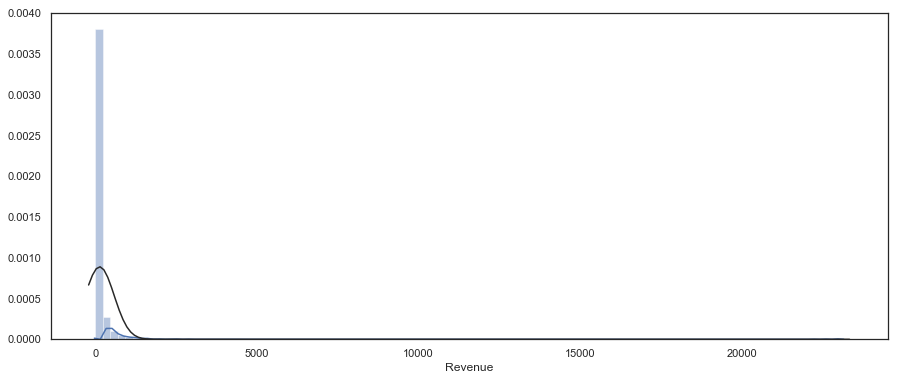

In [321]:
## Plotting out the distribution of spending - to see how much a spread my target is

## Import a normal distribution from scipy
from scipy.stats import norm

## Build a new plot
plt.figure(1, figsize=(15, 6))

## Use a special function in seaborn to build a distribution plot and also include a 
sns.distplot(true_revenue, fit = norm, kde = True, bins = 100)

## Show the plot
plt.show()

In [316]:
true_revenue = training_data["Revenue"][training_data["Revenue"] != 0.0]

In [322]:
max(true_revenue)

23129.5

## Classification Problem Analysis

In [87]:
## What are their splits?  How many of each?
## Just checking to see if the data set is skewed one way or the other - looks like a 2/3 split which should be ok

total_obvs = training_data["Purchase"].value_counts().sum()
total_non_purchase = training_data["Purchase"].value_counts()[0]
total_purchase = training_data["Purchase"].value_counts()[1]

print("{} total non purchases, \
     {} % of overall observations".format(total_non_purchase, round(total_non_purchase/total_obvs*100, 2)))
print("{} total purchases, \
     {} % of overall observations".format(total_purchase, round(total_purchase/total_obvs*100, 2)))

892138 total non purchases,      98.73 % of overall observations
11515 total purchases,      1.27 % of overall observations


## Heavily skewed data set!  Wow.

In [ ]:
## Split data training 80 % and testing 20%

X_train, X_test, y_train, y_test = train_test_split(X, y_classification, test_size = 0.2, random_state = 42,
                                                   stratify = y_classification)

## Bring in testing data for model selection.

In [24]:
## Load in the testing data from the flattened CSV file

testing_data = pd.read_csv(testing_path)

In [25]:
## See the row count of the flattened file

len(testing_data)

804684

In [26]:
## See the first five rows of the testing data

testing_data.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,2314544520795440038,2314544520795440038_1508217442,Not Socially Engaged,1508217442,1,1508217442,Safari,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

categorical_columns = list(training_data_clean[feature_cols].columns[training_data_clean[feature_cols].dtypes == object])
numerical_columns = list(training_data_clean[feature_cols].columns[training_data_clean[feature_cols].dtypes != object])

column_trans = make_column_transformer(
    (categorical_columns, OneHotEncoder(),
    (numerical_columns, RobustScaler())
column_trans.fit_transform(training_data_clean)